#### Bibliotecas

In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union

from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from minisom import MiniSom

from tsai.all import *

import optuna
from optuna.integration import FastAIPruningCallback

from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import torch_optimizer


os.environ["DEVICE"] = "cuda"

## Pré-processamento dos dados

### Cálculo do GPP

In [2]:
set_seed(1, False)
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def constructor_2(path):
    df = pd.read_csv(path, parse_dates=['date'])
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

def df_xy(x,y):
    x_df = pd.DataFrame(x[:,0]).reset_index().drop('index',axis=1)
    x_df.columns = [f'janela {i}' for i in range(len(x_df.columns))]

    y_df = pd.DataFrame(y).reset_index().drop('index',axis=1)
    y_df.columns = [f'previsao {i}' for i in range(len(y_df.columns))]

    return pd.concat([x_df,y_df],axis=1)

@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def read_data():
    with cwd('dados/Merra/dados_otimizados'):
        dados = []
        for csv in sorted(os.listdir()):
            name = csv.split('_')[1]
            df = pd.read_csv(csv)
            datetime = df['index']
            df.index = pd.to_datetime(datetime)
            df = df['GPP']
            smoothed_csv = ExponentialSmoothing(df, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
            dados.append(pd.DataFrame(smoothed_csv,columns=[name],index=datetime))
        return dados

gpp_cax, gpp_peru, gpp_santarem = read_data()
gpp_todos = pd.concat([gpp_peru,gpp_santarem,gpp_cax],axis=1)

### Divisão do dataset em treino e teste

In [3]:
train, test = train_test_split(gpp_todos,test_size=0.15,shuffle=False,random_state=1) # Não embaralhado
train_date = train.index
test_date = test.index

gpp_peru_train, gpp_santarem_train, gpp_cax_train = gpp_peru.loc[train_date].copy(),gpp_santarem.loc[train_date].copy(),gpp_cax.loc[train_date].copy()
gpp_peru_test, gpp_santarem_test, gpp_cax_test = gpp_peru.loc[test_date].copy(),gpp_santarem.loc[test_date].copy(),gpp_cax.loc[test_date].copy()

### Criação da janela temporal

In [4]:
peru_x_test,peru_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_test)                                                                                     
santarem_x_test,santarem_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_test)
cax_x_test,cax_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_test)


# Transformação em Dataframe para melhor manipulação dos dados
peru_xtest = pd.DataFrame(peru_x_test.reshape(-1, 8))
peru_ytest = pd.DataFrame(peru_y_test)
peru_ytest['localidade'] = 'peru'

santarem_xtest = pd.DataFrame(santarem_x_test.reshape(-1, 8))
santarem_ytest = pd.DataFrame(santarem_y_test)
santarem_ytest['localidade'] = 'santarem'

cax_xtest = pd.DataFrame(cax_x_test.reshape(-1, 8))
cax_ytest = pd.DataFrame(cax_y_test)
cax_ytest['localidade'] = 'caxiuana'

x_test_df = pd.concat([peru_xtest,
                       santarem_xtest,
                       cax_xtest,
                       ],
                      ignore_index=True)


y_test_df = pd.concat([pd.DataFrame(peru_ytest),
                       pd.DataFrame(santarem_ytest),
                       pd.DataFrame(cax_ytest),
                       ],
                      ignore_index=True)


X_test = x_test_df.values.reshape(-1, 1, 8) # (n° observações, características, janela de observação)
y_test = y_test_df.drop('localidade',axis=1).values
y_labels = y_test_df['localidade']

In [5]:
peru_x_train,peru_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_train) 
santarem_x_train,santarem_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_train)
cax_x_train,cax_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_train)

peru_df = df_xy(peru_x_train,peru_y_train)
santarem_df = df_xy(santarem_x_train,santarem_y_train)
cax_df = df_xy(cax_x_train,cax_y_train)

peru_df['localidade'] = 'peru'
santarem_df['localidade'] = 'santarem'
cax_df['localidade'] = 'caxiuana'


gpp_geral = pd.concat([peru_df,santarem_df,cax_df]).reset_index().drop('index',axis=1)

### Geração de Características das séries

In [6]:
get_ts_features

<function tsai.data.features.get_ts_features(X: Union[numpy.ndarray, torch.Tensor], y: Union[NoneType, numpy.ndarray, torch.Tensor] = None, features: Union[str, dict] = 'min', n_jobs: Optional[int] = None, **kwargs)>

In [ ]:
previsao = [f'previsao {i}' for i in range(0,8)]

X = gpp_geral.drop(columns=['localidade']).drop(columns=previsao)  # Aqui ficam 8 colunas representado instantes da janela temporal
y = gpp_geral[previsao] # Aqui fica os próximos 8 valores da sequência
z = gpp_geral[['localidade']]

ts_features_df = get_ts_features(X=X.values.reshape(X.shape[0],1,X.shape[1]),y=y.values,features='efficient')
ts_features_df = ts_features_df.dropna(axis=1) # Removendo colunas com valores nulos

Feature Extraction:   0%|                                | 0/60 [00:00<?, ?it/s]

### Clusterização com SOM

In [ ]:
norm = preprocessing.Normalizer()

datos = norm.fit_transform(ts_features_df.values)

map_size = round(np.sqrt(round(5 * np.sqrt(len(ts_features_df))))) # arredondando pra um inteiro com raiz exata = 256 = 16x16

som_shape = [map_size, map_size]
som = MiniSom(som_shape[0], som_shape[1], datos.shape[-1],neighborhood_function='gaussian',activation_distance='euclidean',random_seed=1)

som.train_batch(datos, 500, verbose=False)

# get weights as a (256, 314) array
weights = som.get_weights().reshape(som_shape[0]*som_shape[1], -1)
print("Dimensões da SOM: ",som_shape)

# Cálculo do erro de Kruskal-Shepard
ks_error = kruskal_shepard_error(rectangular_topology_dist(som_shape), datos, som=weights)
print("Erro de Kruskal-Shepard:", ks_error)

#Cálculo do erro de quantização
quantization_error = som.quantization_error(datos)
print("Erro de quantização:", quantization_error)

#Cálculo do erro topográfico
topographic_error = som.topographic_error(datos)
print("Erro topográfico:", topographic_error)

In [ ]:
winner_coordinates = np.array([som.winner(x) for x in datos]).T

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
gpp_geral['cluster'] = np.array(cluster_index)

# Contar o número de ocorrências de cada cluster por localidade
cluster_counts = gpp_geral.groupby(['localidade', 'cluster']).size()

# Filtrar os clusters para apenas os que possuem mais de 6 ocorrências para remover outliers
valid_clusters = cluster_counts[cluster_counts > 6].index

# Manter apenas as linhas cujo cluster e localidade estão nos clusters e localidades válidos
gpp_geral = gpp_geral[gpp_geral.set_index(['localidade', 'cluster']).index.isin(valid_clusters)].copy()

### Divisão Final do Dataset

In [9]:
previsao = [f'previsao {i}' for i in range(0,8)]
X = gpp_geral.drop(columns=['localidade', 'cluster']).drop(columns=previsao) 
y = gpp_geral[previsao]
z = gpp_geral[['localidade','cluster']]

# Dividir os dados em treino e validação estratificados por 'localidade' e 'cluster'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.177, stratify=z,random_state=1)

train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
X_train = train_data.drop(columns=previsao)
y_train = train_data[previsao]

val_data = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
X_val = val_data.drop(columns=previsao)
y_val = val_data[previsao]

X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

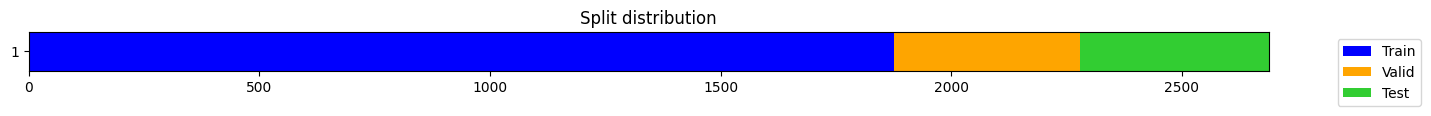

[1876, 404, 408]

In [10]:
X, y, splits = combine_split_data(xs=[X_train_np, X_val_np, X_test_np], ys=[y_train_np, y_val_np, y_test_np])
plot_splits(splits)

tfms = [None, TSForecasting()]
get_splits_len(splits) # [1872, 401, 408] ~= 70%,15%,15%

### Testes com os Modelos

In [11]:
archs = [
         (XCMPlus, {}),
         (ConvTranPlus, {}),
         (TSSequencerPlus, {}),      # Arquiteturas que estou testando (ainda arbitrário).
         (RNNPlus, {}),                         #Os dicionários do lado do nome de cada arquitetura são específicos dos parâmetros
         (ResNetPlus, {}),                              # EX: (LSTM, {'n_layers':1, 'bidirectional': False})
         (InceptionTimePlus, {}),
         (TSTPlus, {}),
         (TransformerLSTMPlus, {}),
         (XceptionTimePlus, {}),
         (TransformerGRUPlus, {}),
         (PatchTST, {}),

        ]

In [12]:
# def test_archs(epochs):
#     results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae_valid','rmse_valid','mae_test','rmse_test','time'])
#     i=0
#     for _, (arch, k) in enumerate(archs):
#         print(arch.__name__)
#         learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=TSStandardize(), arch=arch, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
#         lr = learn.lr_find() # learning rate find
#         start = time.time()
#         learn.fit_one_cycle(epochs, lr_max=lr.valley)
#         elapsed = time.time() - start
#         vals = learn.recorder.values[-1]
#         raw_preds, target, _ = learn.get_X_preds(X[splits[2]], y[splits[2]])
#         mae_test = mean_absolute_error(raw_preds.flatten(),target.flatten())
#         mse_test = mean_squared_error(raw_preds.flatten(),target.flatten())
#         rmse_test = np.sqrt(mse_test)
#         results.loc[i] = [arch.__name__, k, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3],mae_test,rmse_test, int(elapsed)]
#         results.sort_values(by=['mae_valid'], ascending=False, kind='stable', ignore_index=True, inplace=True)
#         clear_output()
#         display(results)
#         i+=1
#     results.to_csv(f'resultados_{epochs}_epocas.csv')

# for epocas in range(50,350,50):
#     test_archs(epocas)

In [14]:
class studies:

    @staticmethod
    def _objective_ConvTranPlus(trial):
        # Categorical parameter
        #arch_name = trial.suggest_categorical('arch',list(architectures.keys()))

        fc_dropout = trial.suggest_float('fc_dropout', 0.1, 0.9)

        encoder_dropout = trial.suggest_float('encoder_dropout', 0.1, 0.9)

        arch_config = {
            'encoder_dropout': encoder_dropout,
            'fc_dropout': fc_dropout,
        }
        
        learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
        Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
        
        standardize_sample = trial.suggest_categorical('by_sample', [True, False])
        standardize_var = trial.suggest_categorical('by_var', [True, False])

        arch = ConvTranPlus

        learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
                            batch_tfms=TSStandardize(by_sample=standardize_sample, by_var=standardize_var),arch=arch,
                            arch_config= arch_config, cbs=FastAIPruningCallback(trial),
                            loss_func=HuberLoss('mean',Huber_delta),seed=1)
                            
        with ContextManagers([learn.no_logging(),learn.no_bar()]):
            learn.fit_one_cycle(50, lr_max=learning_rate_model)
            intermediate_value = learn.recorder.values[-1][1]
        with open("./optuna_tests/ConvTranPlus/{}.pickle".format(trial.number), "wb") as fout:
            pickle.dump(learn, fout)
        return intermediate_value


    @staticmethod
    def _objective_Xception(trial):
        # Categorical parameter
        #arch_name = trial.suggest_categorical('arch',list(architectures.keys()))

        nf = trial.suggest_int('nf', 16, 384,log=True)  # Ajustado para o intervalo original de 16 a 384
        bottleneck = trial.suggest_categorical('bottleneck',[True,False])  # Opções para nb_filters
        ks = trial.suggest_int('ks', 10, 100)

        arch_config = {
            'nf': nf,
            'bottleneck': bottleneck,
            'ks': ks
        }

        learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
        Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
        
        standardize_sample = trial.suggest_categorical('by_sample', [True, False])
        standardize_var = trial.suggest_categorical('by_var', [True, False])

        arch = XceptionTimePlus

        learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
                            batch_tfms=TSStandardize(by_sample=standardize_sample, by_var=standardize_var),arch=arch,
                            arch_config= arch_config, cbs=FastAIPruningCallback(trial),
                            loss_func=HuberLoss('mean',Huber_delta),seed=1)
        
        with ContextManagers([learn.no_logging(),learn.no_bar()]):
                learn.fit_one_cycle(50, lr_max=learning_rate_model)
                intermediate_value = learn.recorder.values[-1][1]
        with open("./optuna_tests/XceptionPlus/{}.pickle".format(trial.number), "wb") as fout:
            pickle.dump(learn, fout)
        return intermediate_value

    @staticmethod
    def get_con_study():
        return run_optuna_study(studies._objective_ConvTranPlus,study_type='randomsearch',n_trials=1000,gc_after_trial=True,direction="minimize",show_plots=False,seed=1)

    @staticmethod
    def get_xception_study():
        return run_optuna_study(studies._objective_Xception,study_type='randomsearch', n_trials=1000,gc_after_trial=True,direction="minimize",show_plots=False,seed=1)


study = studies()

study_xc = study.get_xception_study()
study_conv = study.get_con_study()

print(f"O Melhor modelo foi o de número {study_xc.best_trial.number}")
print(f""" Acesse a pasta optuna_tests/XceptionPlus/{study_xc.best_trial.number}.pickle e coloque o modelo no github """)


print(f"O Melhor modelo foi o de número {study_conv.best_trial.number}")
print(f""" Acesse a pasta optuna_tests/ConvTranPlus/{study_conv.best_trial.number}.pickle e coloque o modelo no github """)

[I 2024-05-08 02:48:06,577] A new study created in memory with name: no-name-99bdc584-4c0f-43cd-be46-a80097140ad3


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-08 03:13:39,222] Trial 0 finished with value: 5.553903102874756 and parameters: {'nf': 102, 'bottleneck': False, 'ks': 99, 'learning_rate_model': 1.2692723741238392e-05, 'Huber_delta': 1.1886603080521008, 'by_sample': True, 'by_var': True}. Best is trial 0 with value: 5.553903102874756.
[I 2024-05-08 03:21:04,663] Trial 1 finished with value: 0.838445246219635 and parameters: {'nf': 33, 'bottleneck': False, 'ks': 99, 'learning_rate_model': 0.0018764422921419897, 'Huber_delta': 1.8930605606642112, 'by_sample': False, 'by_var': True}. Best is trial 1 with value: 0.838445246219635.
[I 2024-05-08 03:47:35,146] Trial 2 finished with value: 0.8273029923439026 and parameters: {'nf': 114, 'bottleneck': False, 'ks': 64, 'learning_rate_model': 0.006669277976260189, 'Huber_delta': 1.7460835213108428, 'by_sample': False, 'by_var': False}. Best is trial 2 with value: 0.8273029923439026.
[I 2024-05-08 04:17:29,487] Trial 3 finished with value: 2.096956253051758 and parameters: {'nf': 168,

[I 2024-05-08 10:30:03,773] A new study created in memory with name: no-name-8e548988-cb73-4731-93a9-cf7fc4ecc88d



Optuna study saved to optuna\no-name-99bdc584-4c0f-43cd-be46-a80097140ad3.pkl
To reload the study run: study = joblib.load('optuna\no-name-99bdc584-4c0f-43cd-be46-a80097140ad3.pkl')

Study statistics    : 
  Study name        : no-name-99bdc584-4c0f-43cd-be46-a80097140ad3
  # finished trials : 125
  # pruned trials   : 112
  # complete trials : 12

Best trial          :
  value             : 0.624359667301178
  best_params = {'nf': 104, 'bottleneck': False, 'ks': 68, 'learning_rate_model': 0.0020766709837544773, 'Huber_delta': 1.0423767923984308, 'by_sample': False, 'by_var': True}



  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath


with open(f"./melhor_modelo_optuna/{805}.pickle", "rb") as fin:
    learner = pickle.load(fin)

In [23]:
raw_preds, target, preds = learner.get_X_preds(X[splits[2]], y[splits[2]])

In [17]:
preds_df = pd.concat([pd.DataFrame(raw_preds),y_labels.to_frame()],axis=1)
target_df = pd.concat([pd.DataFrame(y_test),y_labels.to_frame()],axis=1)

dfs_preds = {}
dfs_target = {}

for localidade in preds_df['localidade'].unique():
    dfs_preds[localidade] = preds_df[preds_df['localidade'] == localidade]

for localidade in target_df['localidade'].unique():
    dfs_target[localidade] = target_df[target_df['localidade'] == localidade]

# Acessando os DataFrames separados

df_peru_pred = dfs_preds['peru'].drop('localidade',axis=1)
df_santarem_pred = dfs_preds['santarem'].drop('localidade',axis=1)
df_caxiuana_pred = dfs_preds['caxiuana'].drop('localidade',axis=1)

df_peru_target = dfs_target['peru'].drop('localidade',axis=1)
df_santarem_target = dfs_target['santarem'].drop('localidade',axis=1)
df_caxiuana_target = dfs_target['caxiuana'].drop('localidade',axis=1)

In [18]:
datas_conj_teste = gpp_peru_test.loc[gpp_peru_test['peru'].isin(y[splits[2]].flatten())].index
datas_conj_teste = pd.to_datetime(datas_conj_teste)

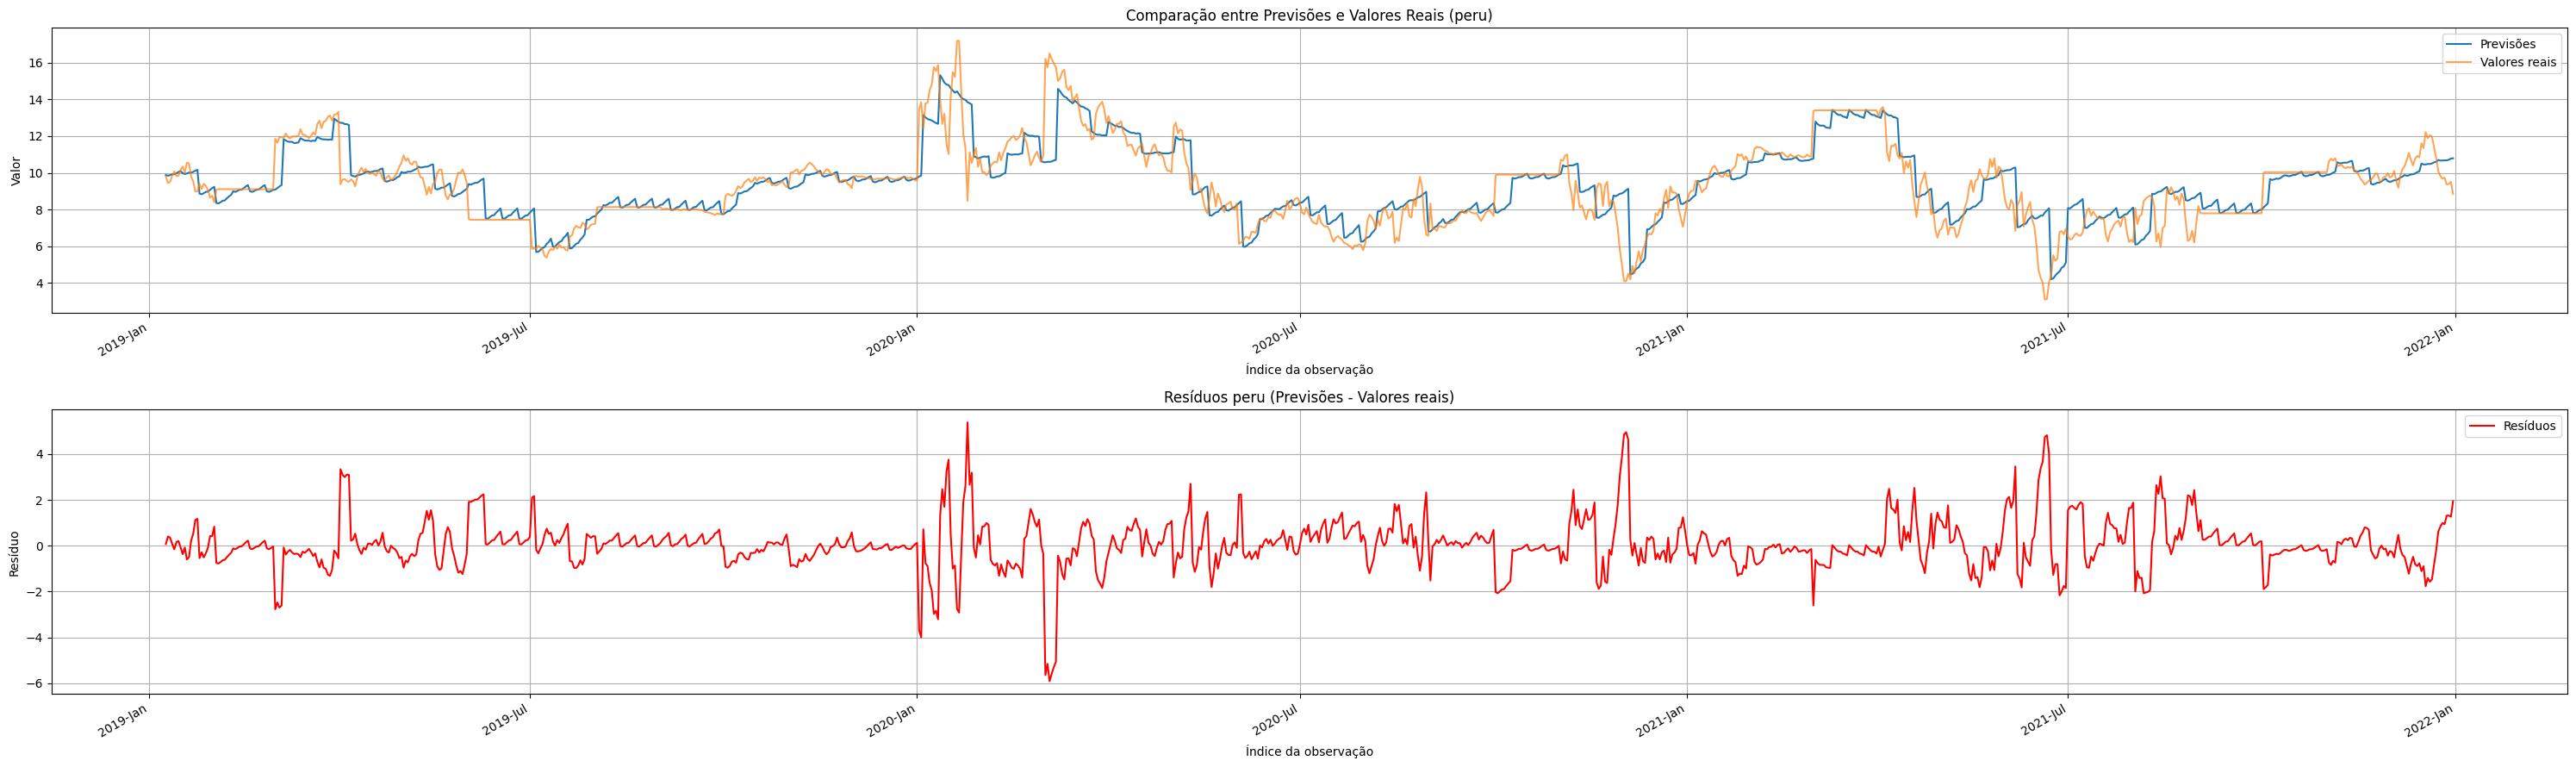

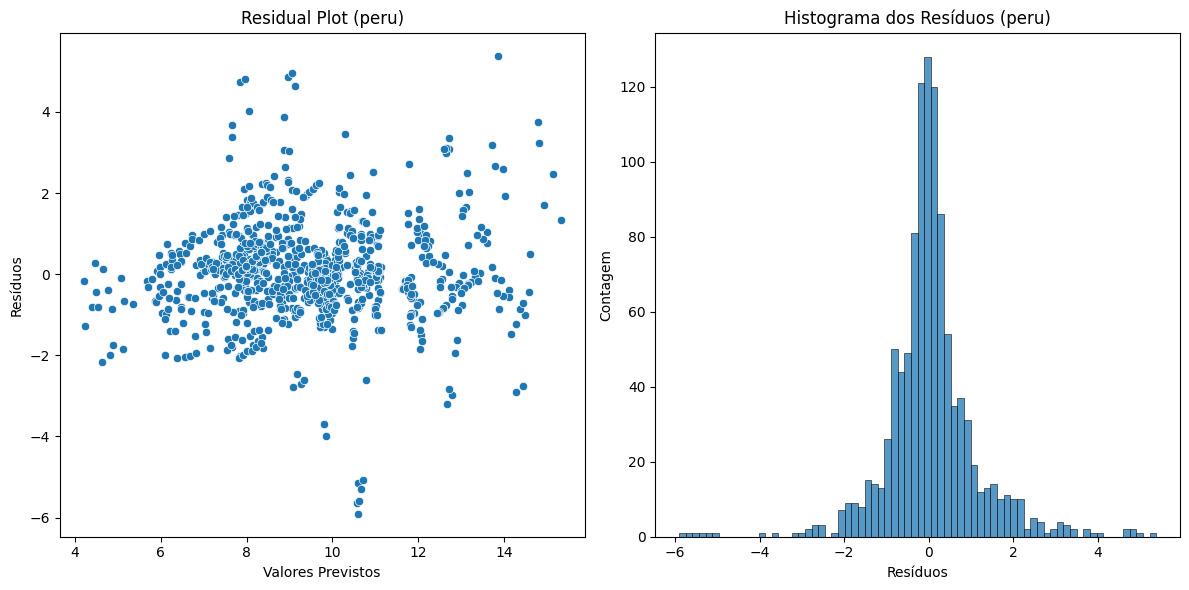

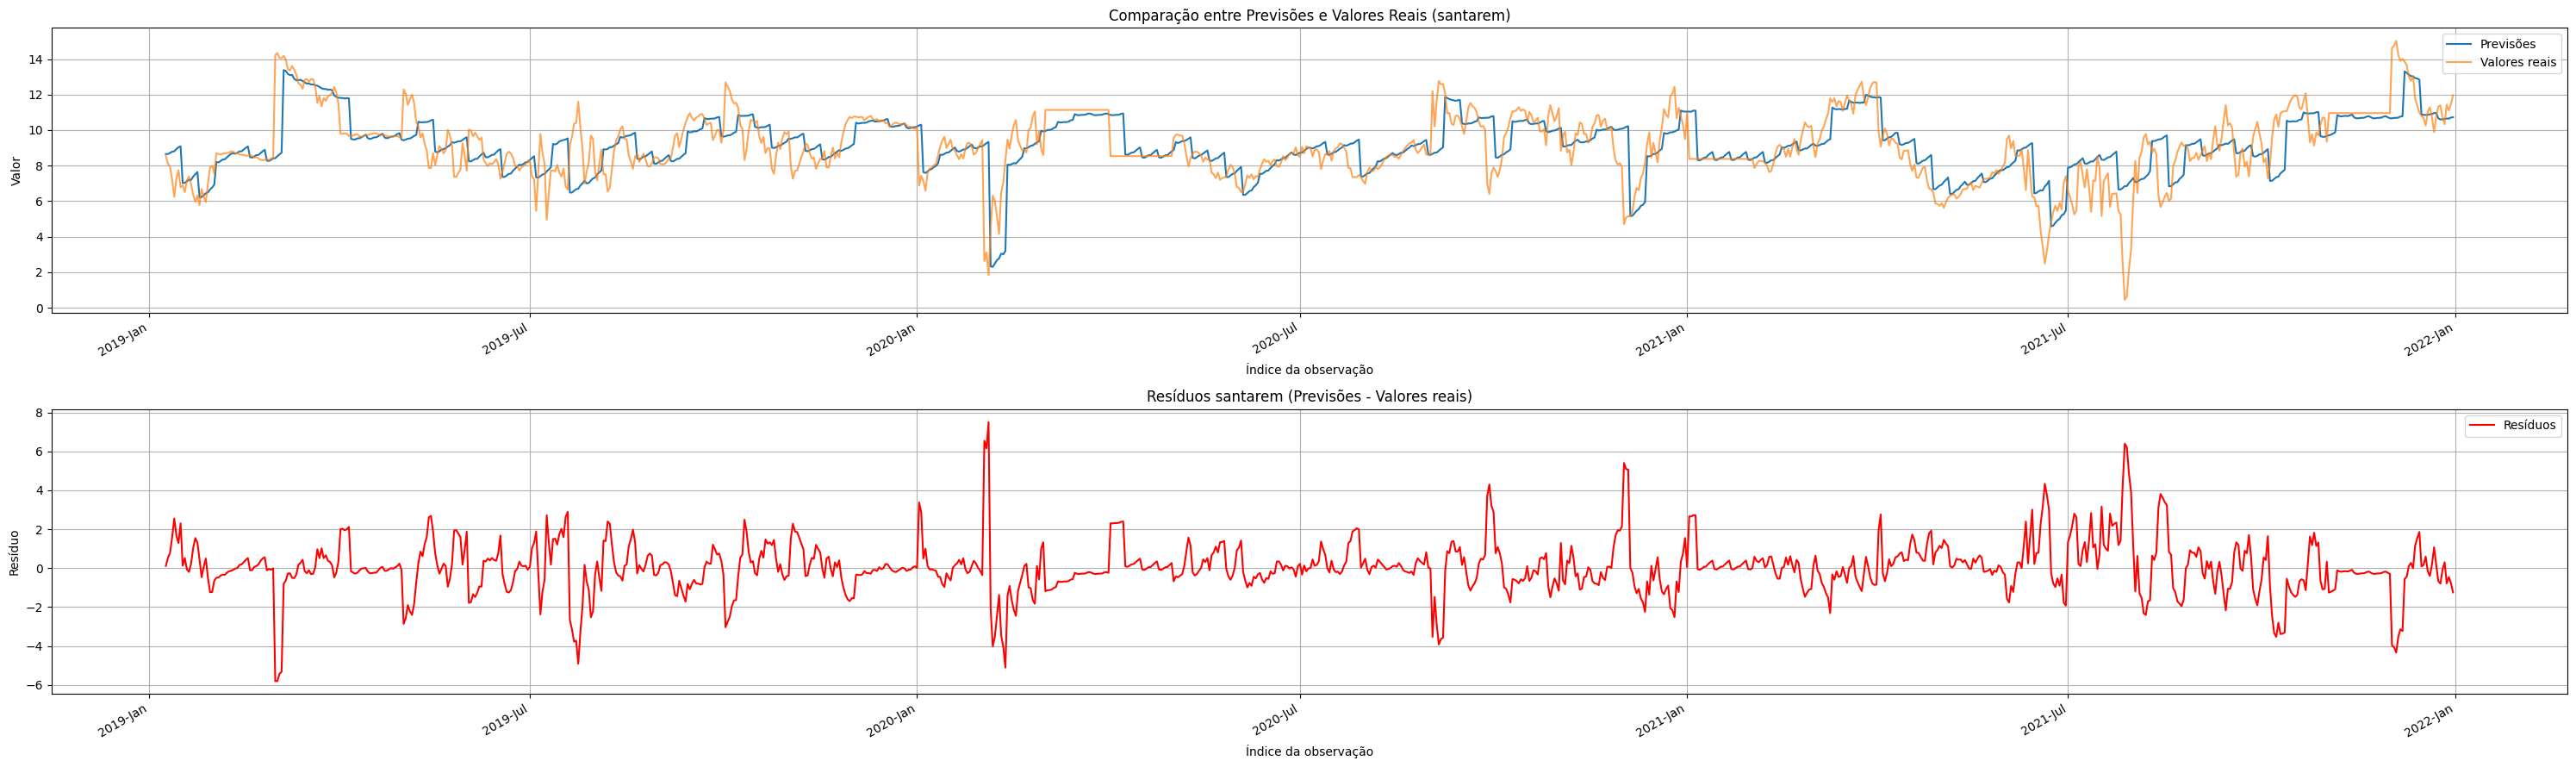

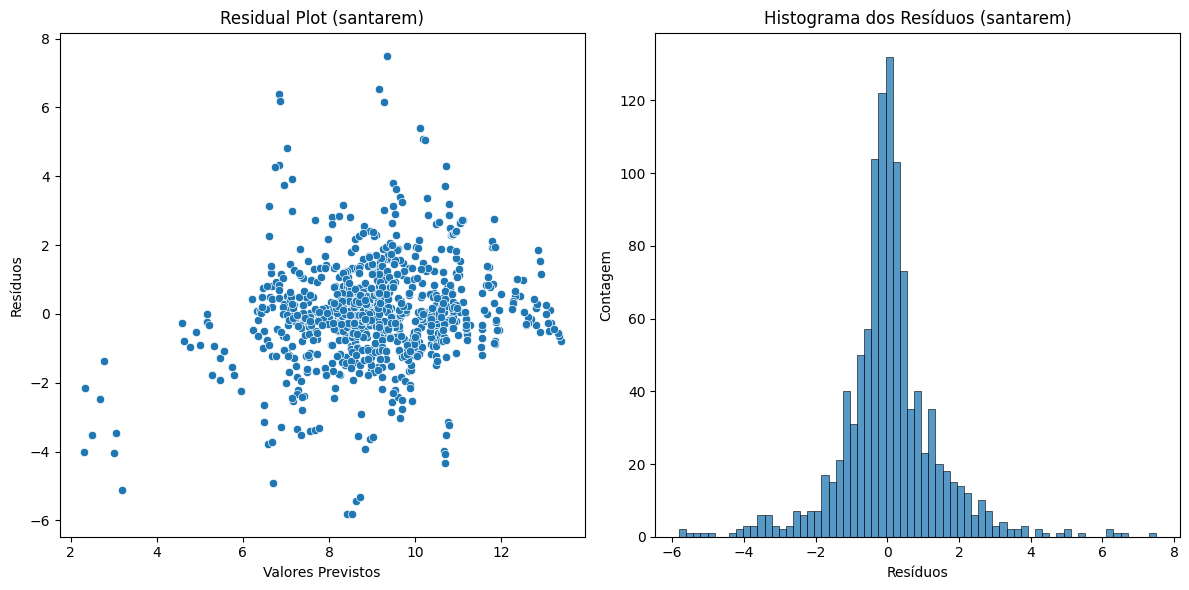

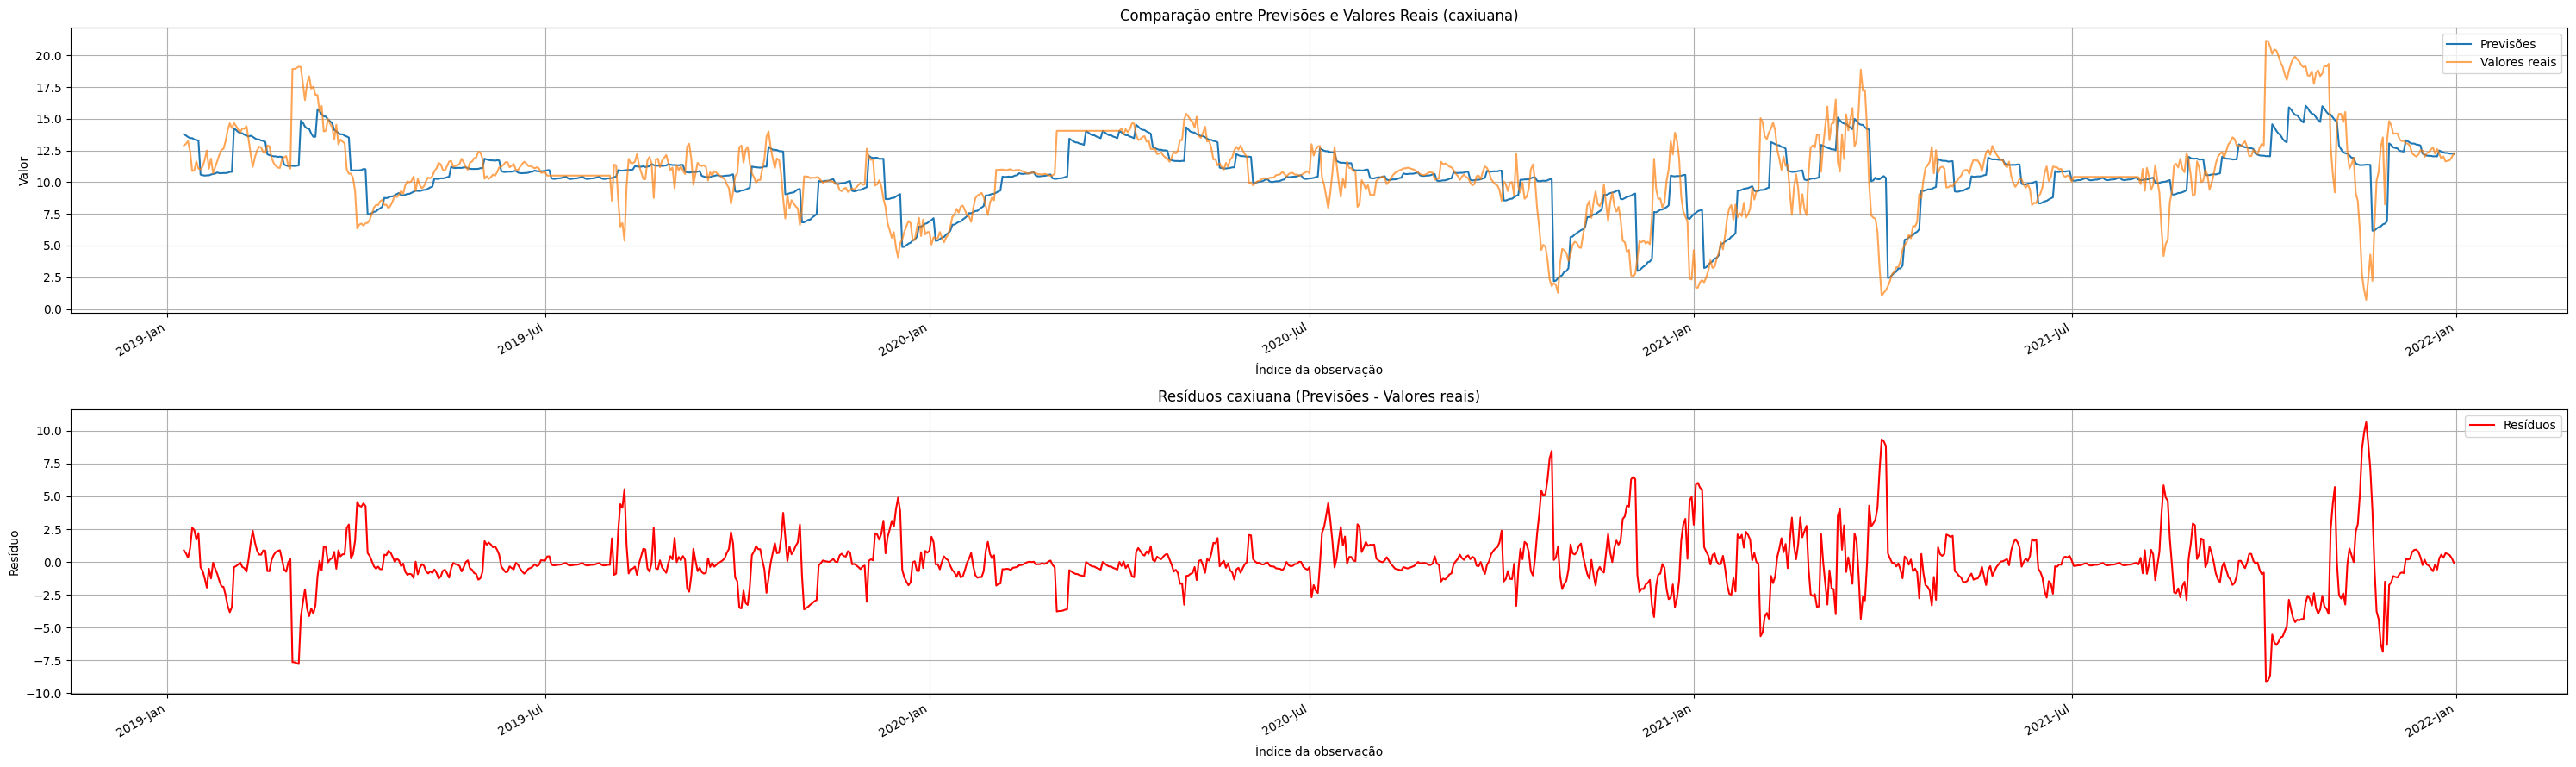

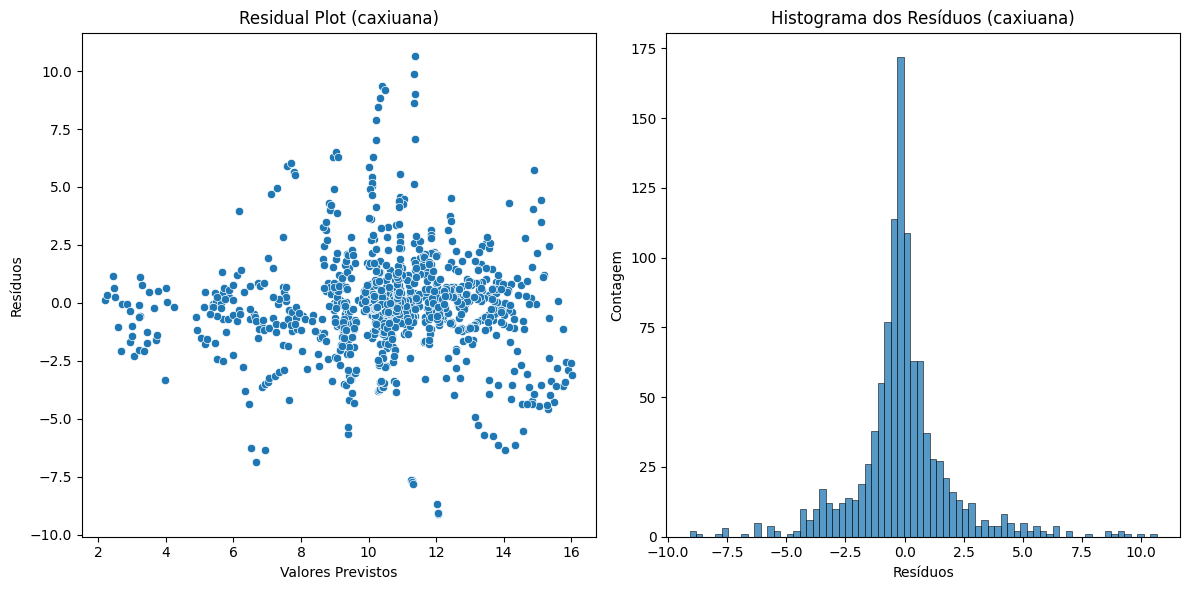

In [19]:
import matplotlib.dates as mdates

def get_summary(df_pred,df_target):
    results = {}
    for i in dfs_preds:
        mae_test = mean_absolute_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        mse_test = mean_squared_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        results[i] = [r2_test,mae_test,rmse_test,np.corrcoef(df_pred[i].drop('localidade',axis=1).values.flatten(), df_target[i].drop('localidade',axis=1).values.flatten())[0][1]]

        residuos = df_pred[i].drop('localidade',axis=1).values - df_target[i].drop('localidade',axis=1).values
        plt.figure(figsize=(30, 9))
        plt.subplot(2, 1, 1)

        plt.plot(datas_conj_teste, df_pred[i].drop('localidade',axis=1).values.flatten(), label='Previsões', alpha=1)
        plt.plot(datas_conj_teste, df_target[i].drop('localidade',axis=1).values.flatten(), label='Valores reais', alpha=0.7)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Valor')
        plt.title(f'Comparação entre Previsões e Valores Reais ({i})')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(datas_conj_teste,residuos.flatten(), label='Resíduos', color='red')

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Resíduo')
        plt.title(f'Resíduos {i} (Previsões - Valores reais)')
        plt.legend()
        plt.grid(True)

        # Seu código para mostrar os gráficos
        plt.tight_layout()
        plt.show()

        residuos_flatten = residuos.flatten()

        # Criar figura e eixos para o subplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot do residual plot
        sns.scatterplot(x=df_pred[i].drop('localidade',axis=1).values.flatten(), y=residuos_flatten, ax=axes[0])
        axes[0].set_title(f'Residual Plot ({i})')
        axes[0].set_xlabel('Valores Previstos')
        axes[0].set_ylabel('Resíduos')

        # Plot do histograma dos resíduos
        sns.histplot(residuos_flatten, ax=axes[1])
        axes[1].set_title(f'Histograma dos Resíduos ({i})')
        axes[1].set_xlabel('Resíduos')
        axes[1].set_ylabel('Contagem')

        # Ajuste o layout
        plt.tight_layout()
        plt.show()


    return pd.DataFrame(results,index=['R²','MAE','RMSE','Corr'])

df_regioes = get_summary(dfs_preds,dfs_target)

In [20]:
mae_geral = mean_absolute_error(raw_preds,target)
mse_geral = mean_squared_error(raw_preds,target)
rmse_geral = np.sqrt(mse_geral)
r2_geral = r2_score(y_pred=raw_preds,y_true=target)

resultados_geral = {}
resultados_geral['Geral'] = [r2_geral,mae_geral,mse_geral,np.corrcoef(raw_preds.flatten(), target.flatten())[0][1]]
resultados_geral = pd.DataFrame(resultados_geral,index=df_regioes.index)

df_geral = pd.concat([df_regioes,resultados_geral],axis=1)
display(df_geral)

,peru,santarem,caxiuana,Geral
R²,0.742406,0.484307,0.582581,0.631932
MAE,0.699601,0.891411,1.326898,0.972636
RMSE,1.091135,1.362990,2.098204,2.483593
Corr,0.862158,0.696744,0.759858,0.791539


In [149]:
gpp_todos.loc[test_date].values.flatten()

(3288,)

In [152]:
learner.recorder.values

[(#1) [0.6354827880859375]]

In [154]:
learner.smooth_loss

tensor(0.8525)